In [1]:
import torch
from model import TunnelNetwork
import matplotlib.pyplot as plt
from partial_data import Cifar10Partial, get_data
import torchvision.transforms as transforms
import numpy as np

### Rank and Acc

In [2]:
def find_threshold(s, thre=0.95):
    count = 0
    total = 0
    total_s = torch.sum(s)
    for i in range(len(s)):
        count += 1
        total += s[i]
        if total / total_s >= thre:
            return count

#### Total MLP

In [3]:
root = "saved_linear/dataset_cifar10_w1024_d7_nd7_init_orthogonal_eps0.1_sample5000_seed6_t2"
acc_list = []
for i in range(7):
    ckpt = torch.load(f"{root}/{i}/model_epoch_99.pth") #model_epoch_99 model_best
    acc = ckpt['train_acc']
    acc_list.append(acc)

all_out = torch.load(root+"/outputs")
all_out = all_out['all_out']
rank_list = []
for i in range(7):
    s = torch.linalg.svdvals(all_out[i])
    rank_list.append(find_threshold(s, thre=0.95))

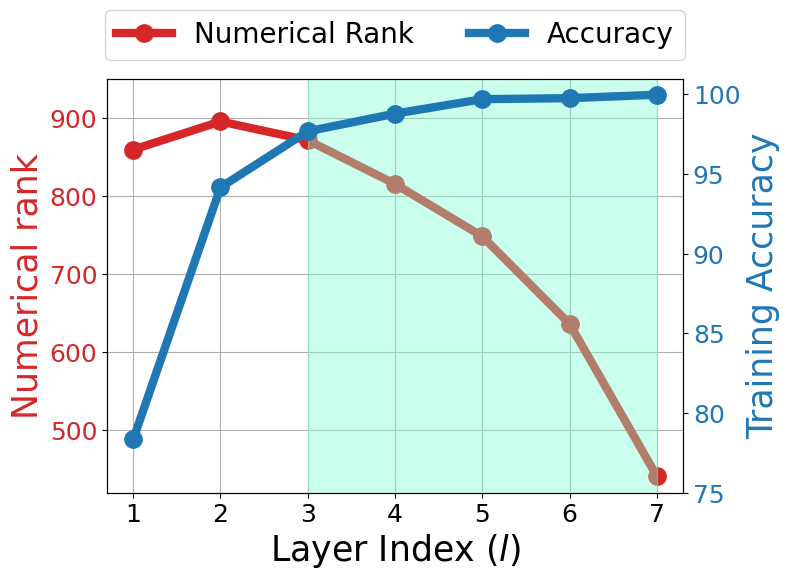

In [7]:
fig, ax1 = plt.subplots(figsize=(8,6))

start_idx = 1
lw = 6
color = 'tab:red'
ax1.set_xlabel(r'Layer Index ($l$)', fontsize=25)
ax1.set_ylabel('Numerical rank', color=color, fontsize=25)
l2 = ax1.plot(np.arange(start_idx,8), rank_list, color=color, linewidth=lw, marker=".", markersize=25,
              label="Numerical Rank")
ax1.tick_params(axis='y', labelcolor=color, labelsize=18)
ax1.set_xticks(np.arange(start_idx,8), np.arange(start_idx,8), fontsize=18)
plt.grid()
ax1.set_ylim(420, 950)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Training Accuracy', color=color, fontsize=25)  # we already handled the x-label with ax1
l4 = ax2.plot(np.arange(start_idx,8), acc_list, color=color, marker=".", linewidth=lw, markersize=25,
          label="Accuracy")
ax2.tick_params(axis='y', labelcolor=color, labelsize=18)
ax2.fill_between(np.arange(3,8), np.min(acc_list)-5, np.max(acc_list)+5, color="#7FFFD4", alpha=0.4)
# ax2.set_ylim(np.min(acc_list)-5, np.max(acc_list)+5)
ax2.set_ylim(75, 101)
lns = l2+l4
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.20), 
           ncols=2, fontsize=20)
# ax2.set_ylim(np.min(acc_list)-1, np.max(acc_list)+1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
# fig.savefig("figs/depth7_nd7_rank_and_acc_v2.png", bbox_inches='tight')

#### Hybrid

In [19]:
root = "saved_linear/dataset_cifar10_w1024_d7_nd3_init_orthogonal_eps0.1_sample5000"
acc_list = []
for i in range(7):
    ckpt = torch.load(f"{root}/{i}/model_epoch_99.pth") #model_epoch_99 model_best
    acc = ckpt['train_acc']
    acc_list.append(acc)

all_out = torch.load(root+"/outputs")
all_out = all_out['all_out']
rank_list = []
for i in range(7):
    s = torch.linalg.svdvals(all_out[i])
    rank_list.append(find_threshold(s, thre=0.95))

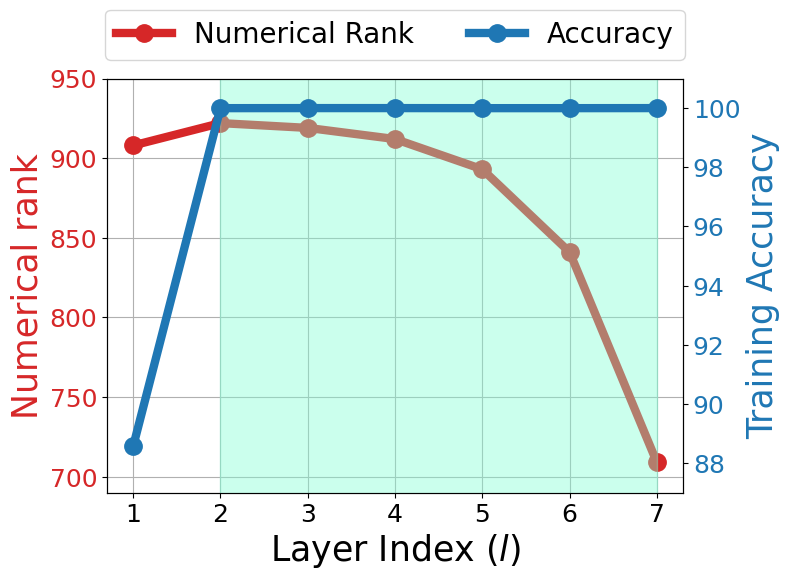

In [23]:
fig, ax1 = plt.subplots(figsize=(8,6))

start_idx = 1
lw = 6
color = 'tab:red'
ax1.set_xlabel(r'Layer Index ($l$)', fontsize=25)
ax1.set_ylabel('Numerical rank', color=color, fontsize=25)
l2 = ax1.plot(np.arange(start_idx,8), rank_list, color=color, linewidth=lw, marker=".", markersize=25,
              label="Numerical Rank")
ax1.tick_params(axis='y', labelcolor=color, labelsize=18)
ax1.set_xticks(np.arange(start_idx,8), np.arange(start_idx,8), fontsize=18)
plt.grid()
ax1.set_ylim(690, 950)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Training Accuracy', color=color, fontsize=25)  # we already handled the x-label with ax1
l4 = ax2.plot(np.arange(start_idx,8), acc_list, color=color, marker=".", linewidth=lw, markersize=25,
          label="Accuracy")
ax2.tick_params(axis='y', labelcolor=color, labelsize=18)
ax2.fill_between(np.arange(2,8), np.min(acc_list)-5, np.max(acc_list)+5, color="#7FFFD4", alpha=0.4)
# ax2.set_ylim(np.min(acc_list)-5, np.max(acc_list)+5)
ax2.set_ylim(87, 101)
lns = l2+l4
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.20), 
           ncols=2, fontsize=20)
# ax2.set_ylim(np.min(acc_list)-1, np.max(acc_list)+1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
# fig.savefig("figs/depth7_nd3_rank_and_acc_v2.png", bbox_inches='tight')

## Compression / Discrimination Plot

#### Total MLP

In [9]:
from utility import *
num_layers = 7
data_dir = '/scratch/qingqu_root/qingqu1/xlxiao/DL/data'
num_classes = 10
sample_size = 5000
root = "saved_linear/dataset_cifar10_w1024_d7_nd7_init_orthogonal_eps0.1_sample5000_seed6_t2"

model = TunnelNetwork(input_dim=3072, hidden_dim=1024, 
                        num_layers=num_layers, output_dim=10,
                        init_method="orthogonal",
                        num_nonlinear_layers=7,
                        eps = 0.1)
train_loader, _ = get_data('cifar10', data_dir, sample_size, 1000, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load(root + "/model_last.pth",
                  map_location=torch.device('cpu'))

model.load_state_dict(ckpt['state_dict'])
mu_c, before_dict = compute_info(model, train_loader, num_layers, device)[1:]
ssw_fro_list, ssb_fro_list, nc1_list, nc1_tilde_list = calculate_nc1(model, train_loader, num_layers, device)

initialize weights using orthogonal!
Files already downloaded and verified
Using Cifar10 with only 10 classes! 

Files already downloaded and verified
Using Cifar10 with only 10 classes! 



/tmp/ipykernel_1717311/545904492.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(np.min(nc1_tilde_list[1:])-1, np.max(nc1_tilde_list[1:])+10)


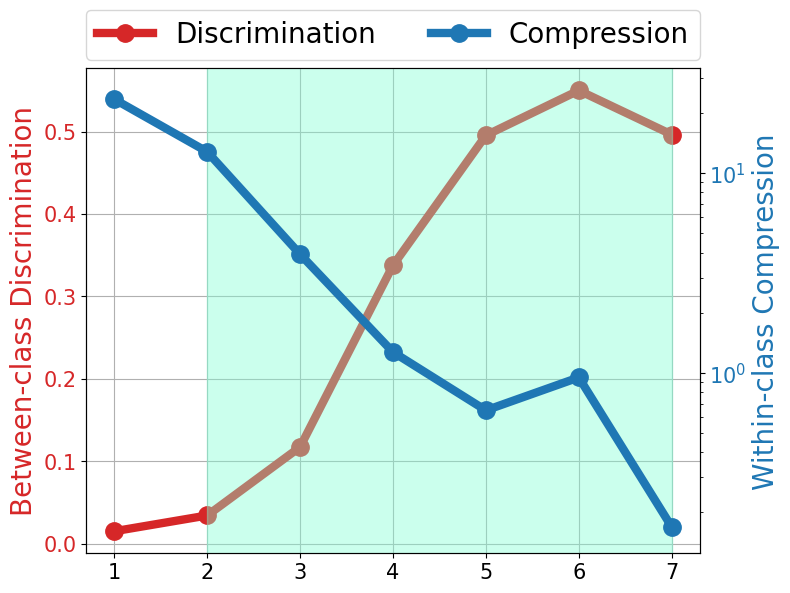

In [ ]:
# Discrimination
mu_c_mat = dict_to_mat(mu_c)
dis = 1-np.array(max_angle_metric(mu_c_mat))

# Plotting
num_layers = 7
fig, ax1 = plt.subplots(figsize=(8,6))

lw=6

color = 'tab:red'
# ax1.set_xlabel('Layer', fontsize=20)
ax1.set_ylabel('Between-class Discrimination', color=color, fontsize=20)
l2 = ax1.plot(np.arange(1,num_layers+1), dis, color=color, linewidth=lw, marker=".",markersize=25, label="Discrimination")
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
ax1.set_xticks(np.arange(1,num_layers+1), np.arange(1,num_layers+1), fontsize=15)
plt.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Within-class Compression', color=color, fontsize=20)  # we already handled the x-label with ax1
l4 = ax2.semilogy(np.arange(1,num_layers+1), nc1_tilde_list[1:], marker=".",markersize=25, color=color, linewidth=lw,
          label="Compression")
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)
ax2.fill_between(np.arange(2,num_layers+1), np.min(nc1_tilde_list[1:])-1, np.max(nc1_tilde_list[1:])+50, color="#7FFFD4", alpha=0.4)
ax2.set_ylim(np.min(nc1_tilde_list[1:])-1, np.max(nc1_tilde_list[1:])+10)
lns = l2+l4
labs = [l.get_label() for l in lns]
# ax2.legend(lns, labs, loc=7, fontsize=15)
ax2.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.15), 
           ncols=2, fontsize=20)
# ax2.set_ylim(np.min(nc1_tilde_list[1:])-1, np.max(nc1_tilde_list[1:])+1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Hybrid

In [24]:
from utility import *
num_layers = 7
data_dir = '/scratch/qingqu_root/qingqu1/xlxiao/DL/data'
num_classes = 10
sample_size = 5000
root = "saved_linear/dataset_cifar10_w1024_d7_nd3_init_orthogonal_eps0.1_sample5000"

model = TunnelNetwork(input_dim=3072, hidden_dim=1024, 
                        num_layers=num_layers, output_dim=10,
                        init_method="orthogonal",
                        num_nonlinear_layers=3,
                        eps = 0.1)
train_loader, _ = get_data('cifar10', data_dir, sample_size, 1000, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load(root + "/model_last.pth",
                  map_location=torch.device('cpu'))

model.load_state_dict(ckpt['state_dict'])
mu_c, before_dict = compute_info(model, train_loader, num_layers, device)[1:]
ssw_fro_list, ssb_fro_list, nc1_list, nc1_tilde_list = calculate_nc1(model, train_loader, num_layers, device)

initialize weights using orthogonal!
Files already downloaded and verified
Using Cifar10 with only 10 classes! 

Files already downloaded and verified
Using Cifar10 with only 10 classes! 



/tmp/ipykernel_1717311/2296252328.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(np.min(nc1_tilde_list[1:])-1, np.max(nc1_tilde_list[1:])+10)


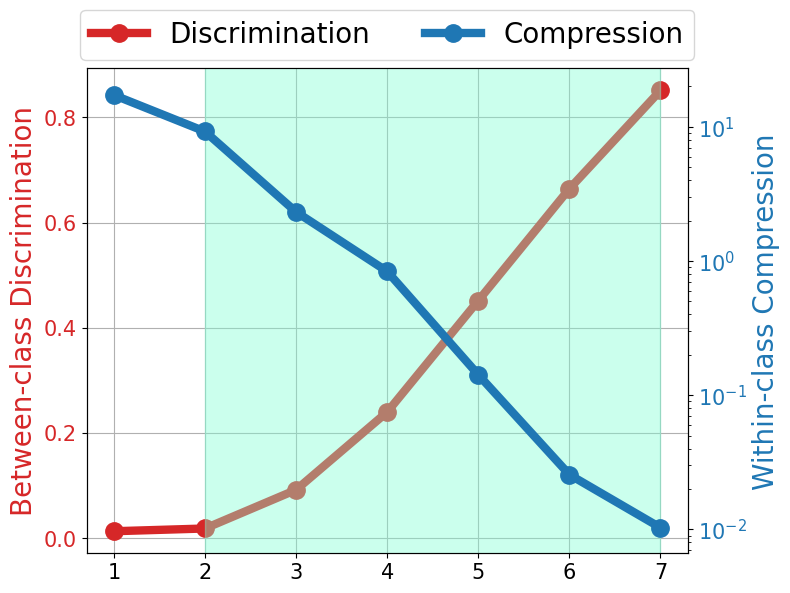

In [ ]:
# Discrimination
mu_c_mat = dict_to_mat(mu_c)
dis = 1-np.array(max_angle_metric(mu_c_mat))

# Plotting
num_layers = 7
fig, ax1 = plt.subplots(figsize=(8,6))

lw=6

color = 'tab:red'
# ax1.set_xlabel('Layer', fontsize=20)
ax1.set_ylabel('Between-class Discrimination', color=color, fontsize=20)
l2 = ax1.plot(np.arange(1,num_layers+1), dis, color=color, linewidth=lw, marker=".",markersize=25, label="Discrimination")
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
ax1.set_xticks(np.arange(1,num_layers+1), np.arange(1,num_layers+1), fontsize=15)
plt.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Within-class Compression', color=color, fontsize=20)  # we already handled the x-label with ax1
l4 = ax2.semilogy(np.arange(1,num_layers+1), nc1_tilde_list[1:], marker=".",markersize=25, color=color, linewidth=lw,
          label="Compression")
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)
ax2.fill_between(np.arange(2,num_layers+1), np.min(nc1_tilde_list[1:])-1, np.max(nc1_tilde_list[1:])+50, color="#7FFFD4", alpha=0.4)
ax2.set_ylim(np.min(nc1_tilde_list[1:])-1, np.max(nc1_tilde_list[1:])+10)
lns = l2+l4
labs = [l.get_label() for l in lns]
# ax2.legend(lns, labs, loc=7, fontsize=15)
ax2.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.15), 
           ncols=2, fontsize=20)
# ax2.set_ylim(np.min(nc1_tilde_list[1:])-1, np.max(nc1_tilde_list[1:])+1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()